# Import and global values

In [50]:
import pandas as pd
import numpy as np

import apimoex
import requests

import matplotlib.pyplot as plt
from numpy.typing import ArrayLike

In [51]:
stock_names = ['RASP', 'GAZP', 'DSKY', 'SBER', 'KMAZ', 'RUAL']
start_date = '2020-04-01' 
end_date = '2022-04-22'

# Functions

In [52]:
def load_data(stock_names=stock_names, start=start_date, end=end_date):
    df = pd.DataFrame()
    with requests.Session() as session:
        for stock in stock_names:
            data = apimoex.get_board_history(session, stock, start=start, end=end, columns=['CLOSE', 'TRADEDATE'])
            df_stock = pd.DataFrame(data)
            df_stock.set_index('TRADEDATE', inplace=True)
            df[stock] = df_stock
    return df


def prepare_r(df_stocks):
    return (df_stocks.shift(-1) / df_stocks).dropna()

In [53]:
def get_grad(r, x):
    return -r / np.dot(r, x)


def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [54]:
def get_this_score(r, x):
    return -np.log(np.dot(r, x))

def get_max_score(r, x):
    return -np.log(np.max(r))

def get_score(r, x):
    return get_this_score(r, x) -  get_max_score(r, x)

def descent_step(this_state, r, alpha):
    x = this_state
    # print("grad of r and x - ", get_grad(r, x))
    new_x = simplex_projection(x - alpha * get_grad(r, x))
    # print('new x - ', new_x)
    return new_x


def descent(begin_state, df_r,lr_scheduler=lambda i: 0.1):
    x = begin_state

    n = df_r.shape[0]

    scores = []
    profit = []
    vectors = [x]

    profit = 1.0
    profit_vec = [profit]

    for i in range(n):
        r = df_r.iloc[i].values
        # print(x)
        score = get_score(r, x)
        scores.append(score)
        alpha = lr_scheduler(i)
        profit *= (r * x).sum()
        profit_vec.append(profit)
        new_x = descent_step(x, r, alpha)
        x = new_x
        vectors.append(new_x)
        # print('r and x before next iteration - ', r, x)

    return (vectors, scores, profit_vec)
    

# Data load

In [76]:
data = load_data()
data_clear = data.dropna()
r = prepare_r(data_clear)

#Visualisation

<AxesSubplot: xlabel='TRADEDATE'>

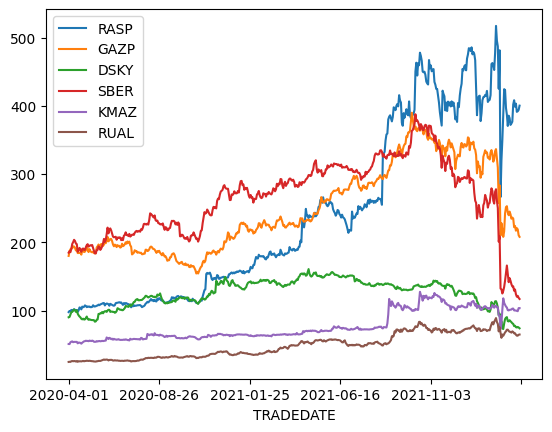

In [78]:
data_clear.plot()

In [79]:
data_clear

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,97.76,180.06,90.12,184.78,51.0,24.755
2020-04-02,99.40,187.04,90.62,186.95,50.9,24.955
2020-04-03,99.10,189.77,94.42,185.64,53.6,24.830
2020-04-06,100.92,191.10,97.80,190.70,54.4,25.755
2020-04-07,98.98,191.22,98.12,197.63,54.8,26.050
...,...,...,...,...,...,...
2022-04-18,403.15,216.99,75.60,123.85,100.1,64.605
2022-04-19,391.15,220.72,75.20,120.30,99.5,63.200
2022-04-20,392.00,218.92,75.98,121.50,99.1,63.200


#Safe method (no more than 50% of portfolio in one company)

In [80]:
safe_alpha_array = np.logspace(1, 10, 1000, base=4) * 0.0001

In [81]:
safe_best_alpha = -1
safe_max_profit = [0]

for i in safe_alpha_array:
    vectors, scores, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, lr_scheduler=lambda x: i)
    if np.max(vectors) > 0.5:
      safe_best_alpha = i
      safe_max_profit = profit
      break

In [99]:
safe_best_alpha

0.38480448794526567

In [82]:
safe_profit_to_date = pd.DataFrame(index=data_clear.index, columns=["profit"])
safe_profit_to_date['profit'] = safe_max_profit

<AxesSubplot: xlabel='TRADEDATE'>

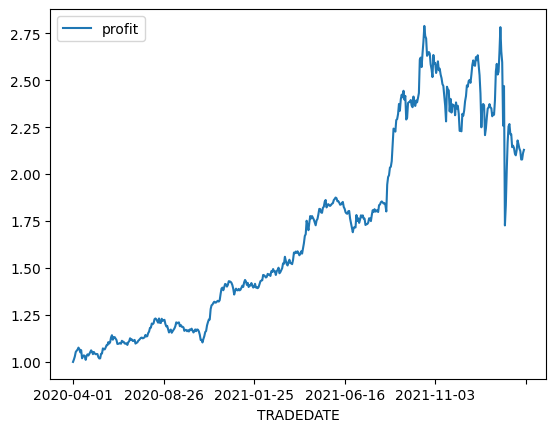

In [84]:
safe_profit_to_date.plot()

In [85]:
#final profit
safe_profit_to_date['profit'][-1]

2.1291059074006666

#Unsafe method

In [86]:
unsafe_alpha_array = np.logspace(1, 10, 1000, base=5.1) * 0.0001

In [87]:
unsafe_max_profit = [0]
unsafe_best_alpha = -1.0

for i in unsafe_alpha_array:
    vectors, scores, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, lr_scheduler=lambda x: i)
    if profit[-1] > unsafe_max_profit[-1]:
      unsafe_max_profit = profit
      unsafe_best_alpha = i

In [101]:
unsafe_best_alpha

0.43635803556937275

In [89]:
unsafe_profit_to_date = pd.DataFrame(index=data_clear.index, columns=["profit"])
unsafe_profit_to_date['profit'] = unsafe_max_profit

<AxesSubplot: xlabel='TRADEDATE'>

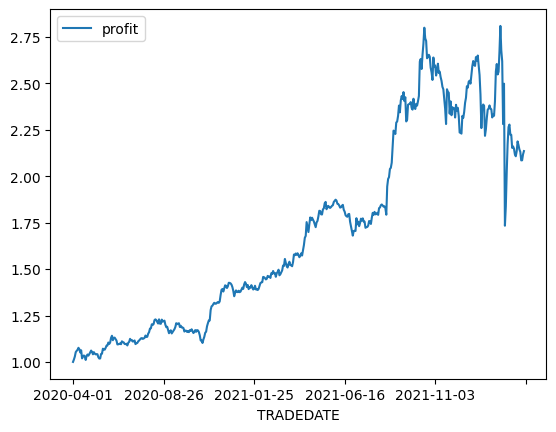

In [90]:
unsafe_profit_to_date.plot()

In [92]:
#final profit
unsafe_profit_to_date['profit'][-1]

2.1356268078260854